Integral of x + x^3 over [0, 1]: 0.75, Error: 8.680555555555556e-05


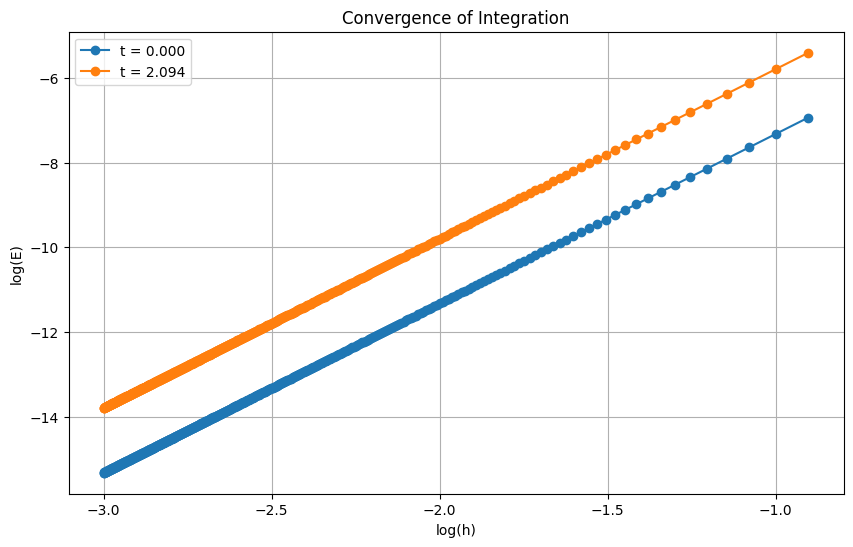

⟨r⟩ = 4.725897920604916, ⟨r^2⟩ = 1.0, Variance = -21.334111155977865
Mean radius: 4.725897920604916, Standard deviation: 0.0
Wavefunction normalization: 1.0, Error: 2.385933281728956e-13


In [1]:
import numpy as np
from scipy.integrate import quad
import matplotlib.pyplot as plt
import pandas as pd

def fill_array(function, interval, num_points):

    x_values = np.linspace(interval[0], interval[1], num_points)
    y_values = function(x_values)
    h = (interval[1] - interval[0]) / (num_points - 1)
    return x_values, y_values, h

def integrate_newton_cotes(y_values, h):#Numerical integration


    n = len(y_values)

    if n % 2 == 0:
        integral = 0
        weights = np.ones(n - 1)
        weights[1:-1:2] = 4
        weights[2:-1:2] = 2
        integral += h / 3 * np.dot(weights, y_values[:-1])

        last_weights = np.array([1, 3, 3, 1])
        integral += 3 * h / 8 * np.dot(last_weights, y_values[-4:])
    else:
        weights = np.ones(n)
        weights[1:-1:2] = 4
        weights[2:-1:2] = 2
        integral = h / 3 * np.dot(weights, y_values)

    error_estimate = (h ** 4 / 90) * np.abs(y_values[-1] - y_values[0])
    return integral, error_estimate

def integrate_with_quad(func, interval): #Integrate a function 

    result, error = quad(func, interval[0], interval[1], epsabs=1e-12, epsrel=1e-12)
    return result, error

def particle_probability_extended(): #Compute the probability of a particle

    L = 2  
    omega1, omega2 = 3, 4.5
    delta_omega = omega2 - omega1
    times = [0, np.pi / delta_omega]
    interval = (3 * L / 4, L)  
    results = {t: [] for t in times}
    csv_data = [] 

    def wavefunction(x, t):
        return (1 / np.sqrt(L)) * (
            np.sin(np.pi * x / L) * np.exp(-1j * omega1 * t) +
            np.sin(2 * np.pi * x / L) * np.exp(-1j * omega2 * t)
        )

    def probability_density(x, t):
        psi = wavefunction(x, t)
        return np.abs(psi) ** 2

    #Loop
    for n in range(5, 502):
        h = (interval[1] - interval[0]) / (n - 1)  

        for t in times:
           
            x_vals, prob_density_vals, _ = fill_array(lambda x: probability_density(x, t), interval, n)

           
            integral, error = integrate_newton_cotes(prob_density_vals, h)

            #Store results
            results[t].append((n, np.log10(error), np.log10(h)))
            csv_data.append({"n": n, "t": t, "log(E)": np.log10(error), "log(h)": np.log10(h)})

    #Save to CSV
    df = pd.DataFrame(csv_data)
    df.to_csv("particle_probability_results.csv", index=False)

    return results

def plot_convergence(results): #plot log(E) vs log(h)

    plt.figure(figsize=(10, 6))

    for t, data in results.items():
        n_vals, log_E, log_h = zip(*data)
        label = f"t = {t:.3f}"
        plt.plot(log_h, log_E, marker="o", label=label)

    plt.xlabel("log(h)")
    plt.ylabel("log(E)")
    plt.title("Convergence of Integration")
    plt.legend()
    plt.grid()
    plt.show()

def hydrogen_2s_mean_radius_adaptive(): #mean radius and standard deviation for the 2s hydrogen

    a0 = 0.0529  #Bohr radius in nm

    def wavefunction_2s(r):
        return (1 / (4 * np.sqrt(2 * np.pi) * a0 ** 1.5)) * (2 - r / a0) * np.exp(-r / (2 * a0))

    def radial_integrand(r, n):
        psi = wavefunction_2s(r)
        return (4 * np.pi) * psi ** 2 * r ** n

    interval = (0, 200 * a0) 

    #Calculate the mean radius ⟨r⟩
    mean_radius, mean_radius_error = integrate_with_quad(lambda r: radial_integrand(r, 1), interval)

    #Calculate the second moment ⟨r^2⟩
    second_moment, second_moment_error = integrate_with_quad(lambda r: radial_integrand(r, 2), interval)

    #Compute variance ⟨r^2⟩ - ⟨r⟩^2
    variance = second_moment - mean_radius ** 2
    print(f"⟨r⟩ = {mean_radius}, ⟨r^2⟩ = {second_moment}, Variance = {variance}")
    if variance < 0:
        print("Warning: Variance is negative.")
        variance = max(variance, 0)

    standard_deviation = np.sqrt(variance)
    return mean_radius, standard_deviation

def test_normalization():
    a0 = 0.0529

    def wavefunction_2s(r):
        return (1 / (4 * np.sqrt(2 * np.pi) * a0 ** 1.5)) * (2 - r / a0) * np.exp(-r / (2 * a0))

    def radial_probability_density(r):
        psi = wavefunction_2s(r)
        return 4 * np.pi * r**2 * psi**2

    norm, error = integrate_with_quad(radial_probability_density, (0, 200 * a0))
    print(f"Wavefunction normalization: {norm}, Error: {error}")

if __name__ == "__main__":
    
    def polynomial(x):
        return x + x ** 3

    interval = (0, 1)
    x_vals, y_vals, h = fill_array(polynomial, interval, 5)
    integral, error = integrate_newton_cotes(y_vals, h)
    print(f"Integral of x + x^3 over [0, 1]: {integral}, Error: {error}")
    
    results = particle_probability_extended()
    plot_convergence(results)

    mean_radius, std_dev = hydrogen_2s_mean_radius_adaptive()
    print(f"Mean radius: {mean_radius}, Standard deviation: {std_dev}")
    test_normalization()

In [2]:
#Load CSV file 
df = pd.read_csv("particle_probability_results.csv")
print(df.head())

   n         t    log(E)    log(h)
0  5  0.000000 -6.934214 -0.903090
1  5  2.094395 -5.403111 -0.903090
2  6  0.000000 -7.321854 -1.000000
3  6  2.094395 -5.790751 -1.000000
4  7  0.000000 -7.638579 -1.079181


#### a) The 2nd-order Newton-Cotes method (Simpson's Rule) is designed to perfectly integrate polynomials of degree up to 3, which explains the really low error
#### b) The convergence plot of log(E) vs log(h) showed a linear relationship between the slopes close to 4, which is consistent with the O(h^4) theoretical convergence rate for the 2nd-order Newton-Cotes method. This confirms that the numerical results align with the expected behavior.